In [2]:
machine = 'mac'
machine = 'magny'

In [3]:
if machine == 'magny':
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
    filedir = "/home/extmilan/masterthesis/files/"
    plotdir = "/home/extmilan/masterthesis/plots/"
elif machine == 'mac': 
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
    filedir = "/Users/smilanov/Documents/masterthesis/auriga_files/files/"
    plotdir = "/Users/smilanov/Documents/masterthesis/auriga_files/plots/"
    
#file = filedir + 'potential_params_10000_with_initeqbestfit.txt'

#dopotfit = True

In [4]:
from galpy.potential import NFWPotential as NFWpot
from galpy.potential import HernquistPotential as HEpot
from galpy.potential import DoubleExponentialDiskPotential as DEpot
from galpy.potential import MiyamotoNagaiPotential as MNpot
from galpy.potential import MN3ExponentialDiskPotential as MN3pot
from galpy.potential import MWPotential2014
from galpy.potential import evaluatePotentials, MiyamotoNagaiPotential, NFWPotential, HernquistPotential


from galpy.potential import evaluateDensities, evaluatePotentials
from galpy.potential import plotDensities
from galpy.potential import plotRotcurve
from galpy.util import bovy_conversion

import emcee

import numpy as np

from scipy import optimize as opt
from scipy import integrate

from astropy import units

from IPython.display import display

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import copy

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind

from auriga_basics import *
from auriga_functions import *

import datetime
import random

%matplotlib inline

Build the potential
---
- Disk: Miyamoto Nagai (http://adsabs.harvard.edu/abs/1975PASJ...27..533M 
- Spheroid: Hernquist (http://adsabs.harvard.edu/abs/1990ApJ...356..359H)
- Halo: NFW (http://iopscience.iop.org/article/10.1086/304888/pdf)

$v_{circ} = \sqrt{R\frac{\partial\Phi}{\partial R}}$

Miyamoto Nagai potential
--

$\Phi_{MN} (R,z) = -\frac{GM}{\sqrt{R^2 + \left(a + \sqrt{z^2 + b^2}\right)^2}}$

$\rho_{MN} (R,z) = \frac{b^2M}{4\pi}
\frac{aR^2 + \left(a + 3\sqrt{z^2 + b^2}\right)\left(a + \sqrt{z^2 + b^2}\right)^2}
{\left[R^2 + \left(a + \sqrt{z^2 + b^2}\right)^2\right]^{5/2}\left(z^2 + b^2\right)^{3/2}}$

$
v_{circ_{MN}}(R,z)     = R \sqrt{
\frac
{ GM }
{ \left(R^2 + \left(a + \sqrt{z^2+b^2}\right)^2\right)^{3/2} }
}
$

Hernquist potential
--
$\Phi_H(r) = -\frac
{GM}
{r+a}
$

$\rho_H(r) = \frac{M}{2\pi}\frac{r}{a}\frac{1}{\left(r+a\right)^3}
$

$M_H(r) = M \frac{r^2}{(r+a)^2}$

$v_{circ_H}(r) = \frac
{\sqrt{GMr} }
{r+a} 
= \sqrt{\frac{GM(<r)}{r}}
$
    last equation part only valid in spherical symmetric systems
    
NFW potential 
--

1. fit MND and HB
2. calculate their circular velocities
3. calculate total velocity and get circular velocity of NFW by subtracting: $v_{circ_{NFW}} = \sqrt{v_{circ_{tot}}^2 - v_{circ_{MND}}^2 - v_{circ_{HB}}^2}$
4. setup galpy potential with fixed MND and HB with fitted vals and just fit NFW parameters to pot vals
5. (possible check: fit also v0 of NFW and compare to 'real' one)



In [5]:
### fit disk

# try to integrate numerically for poisson process
# take eq 2.69b (w/o mass) B&T08
# if that does not work fit to binned densities

Rmin_kpc = 1.
Rmax_kpc = 10.

def rho_MND(R_kpc, z_kpc, phi, a_kpc = 5., b_kpc = 1., specific = True, mass_10Msun = None):
    """
    INPUT:
        R_kpc, z_kpc: 
    """
    #a_kpc = args[0]
    #b_kpc = args[1]
    if specific == True:
        first_fac_kpc2 = b_kpc**2 / (4. * np.pi)
    else:
        first_fac_kpc2 = (mass_10Msun * b_kpc**2) / (4. * np.pi) # * 10^10M_sun
    bzsqrt_kpc = np.sqrt(z_kpc**2 + b_kpc**2)
    abz_sqrt_kpc = (a_kpc + bzsqrt_kpc)
    numerator_kpc3 = a_kpc * R_kpc**2 + (a_kpc + 3. * bzsqrt_kpc) * abz_sqrt_kpc**2
    denominator_kpc8 = (R_kpc**2 + abz_sqrt_kpc**2)**(5./2.) * bzsqrt_kpc**3
    rho_kpc_3 = first_fac_kpc2 * numerator_kpc3 / denominator_kpc8 # * 10^10 M_sun if not specific density
    return (rho_kpc_3)
    
def prob_MND(Rs, zs, a_kpc, b_kpc, Rmin_kpc, Rmax_kpc):
    res, res_err = integrate.tplquad(rho_MND, 0., 2. * np.pi, lambda phi: -np.inf, lambda phi: np.inf,
                  lambda phi, z_kpc: Rmin_kpc, lambda phi, z_kpc: Rmax_kpc, args = (a_kpc, b_kpc))
    rho = rho_MND(Rs, zs, a_kpc, b_kpc)
    p = rho / res
    return(p)

def likelihood_MND(Rs, zs, a_kpc, b_kpc, Rmin_kpc, Rmax_kpc):
    p = prob_MND(Rs, zs, a_kpc, b_kpc, Rmin_kpc, Rmax_kpc)
    logL = np.sum(np.log10(p))
    return logL

#_____function for scipy.differential_evolution that sums the relative error squares_____
def log_MND_scipydifferentialevolution(x, *args):
    
    # read fitting parameters:
    a_MND_kpc  = x[0]
    b_MND_kpc  = x[1]
    
    # read data:
    R_kpc_data    = args[0]
    z_kpc_data    = args[1]
    _REFR0_kpc    = args[2]
    Rmin_kpc      = args[3]
    Rmax_kpc      = args[4]
    
    logL_MND = likelihood_MND(R_kpc_data, z_kpc_data, a_MND_kpc, b_MND_kpc, Rmin_kpc, Rmax_kpc)
    #print(a_MND_kpc)
    #print(logL_MND)
    return (logL_MND)

def fit_MND(R_kpc_data, z_kpc_data, _REFR0_kpc = 8., Rmin_kpc = 1., Rmax_kpc = 10.):
    lower_floor = 1e-3
    bounds = ((lower_floor, 50.),  # a_MND
              (lower_floor, 10.))  # b_MND
              
    #fitting:
    res = opt.differential_evolution(
                log_MND_scipydifferentialevolution,
                bounds = bounds,
                args = (R_kpc_data, z_kpc_data, _REFR0_kpc, Rmin_kpc, Rmax_kpc),
                strategy = 'best1bin',
                maxiter = 1000, tol=0.01, atol=1e-7,
                disp = False
                )

    a_MND_kpc_bestfit  = res.x[0]
    b_MND_kpc_bestfit  = res.x[1]
    return(a_MND_kpc_bestfit, b_MND_kpc_bestfit)

def v_circ_MND_func(R_kpc_data, z_kpc_data, M_tot_10Msun, R0_kpc, z0_kpc = 0.):
    a_MND_kpc, b_MND_kpc = fit_MND(R_kpc_data, z_kpc_data, _REFR0_kpc = R0_kpc)
    denom = (R0_kpc**2 + (a_MND_kpc + np.sqrt(z0_kpc**2 + b_MND_kpc**2))**2)**(3./2.)
    v_circ = R0_kpc * np.sqrt(43.01e3* M_tot_10Msun / denom)
    return(a_MND_kpc, b_MND_kpc, v_circ)

def v_circ_MND_ab(R_kpc, z_kpc, a_MND_kpc, b_MND_kpc, M_tot_10Msun):
    denom = (R_kpc**2 + (a_MND_kpc + np.sqrt(z_kpc**2 + b_MND_kpc**2))**2)**(3./2.)
    v_circ = R_kpc * np.sqrt(43.01e3* M_tot_10Msun / denom)
    return(v_circ)

def MND(R_kpc_data, z_kpc_data, M_tot_10Msun, R0_kpc, z0_kpc = 0.):
    print('Start MND fit at', datetime.datetime.now().time())
    a_MND_kpc, b_MND_kpc, v_circ = v_circ_MND_func(R_kpc_data, z_kpc_data, M_tot_10Msun, R0_kpc, z0_kpc)
    print('MND: a[kpc], b[kpc], vcirc [km/s]:', a_MND_kpc, b_MND_kpc, v_circ)
    return(a_MND_kpc, b_MND_kpc, v_circ)

In [6]:
### fit bulge

def rho_data(M_stars_10Msun, r_kpc, dr_kpc, log = True):
    
    rmin_kpc, rmax_kpc = np.min(r_kpc), np.max(r_kpc)

    rbins_kpc = np.arange(rmin_kpc, rmax_kpc, dr_kpc)
    rbins_log_kpc = np.logspace(np.log10(rmin_kpc), np.log10(rmax_kpc), 97)
    mbins_10Msun = np.zeros(len(rbins_kpc))
    volbins_kpc3 = np.zeros(len(rbins_kpc))
    if log == False:
        for i in range(len(rbins_kpc)):
            inbin = (rbins_kpc[i] <= r_kpc) & (r_kpc < (rbins_kpc[i] + dr_kpc)) # spherical shells
            mbins_10Msun[i] = np.sum(M_stars_10Msun[inbin])
            volbins_kpc3[i] = 4./3. * np.pi * dr_kpc * (3. * rbins_kpc[i]**2 + 3. * rbins_kpc[i] * dr_kpc + dr_kpc**2)
    elif log == True:
        mbins_10Msun = np.zeros(len(rbins_log_kpc))
        volbins_kpc3 = np.zeros(len(rbins_log_kpc))
        dr_log_kpc = np.log(rbins_log_kpc[1]/rbins_log_kpc[0])
        for i in range(len(rbins_log_kpc)):
            inbin = (rbins_log_kpc[i] <= r_kpc) & (r_kpc < (rbins_log_kpc[i] + dr_log_kpc)) # spherical shells
            mbins_10Msun[i] = np.sum(M_stars_10Msun[inbin])
            volbins_kpc3[i] = 4./3. * np.pi * dr_log_kpc * (3. * rbins_log_kpc[i]**2 + 3. * rbins_log_kpc[i] * dr_log_kpc + dr_log_kpc**2)

        
    rho_10Msun_kpc3 = mbins_10Msun / volbins_kpc3
    return(rho_10Msun_kpc3, rbins_log_kpc)

'''
def HB(v0_kms, a_HB_kpc, r_kpc, z_kpc, _REFR0_kpc, normalize = True):
    HB = HernquistPotential(a_HB_kpc, normalize=normalize)
    rho_model_galpy = evaluateDensities(HB, r_kpc, z_kpc) 
    rho_model_10Msun_kpc3 = rho_model_galpy * bovy_conversion.dens_in_msolpc3(v0_kms, _REFR0_kpc) * 10.
    return(rho_model_10Msun_kpc3)
'''


def Hernquistdens(r_kpc, a_HB_kpc, amp_10Msun):
    rho_10Msun_kpc3 = amp_10Msun / (4. * np.pi * a_HB_kpc**3.) * (1. / ((r_kpc / a_HB_kpc) * (1. + r_kpc / a_HB_kpc)**3))
    return(np.log(rho_10Msun_kpc3))
    
def fit_HB(M_stars_10Msun, r_kpc, dr_kpc):
    rho_data_10Msun_kpc3, rbins_kpc = rho_data(M_stars_10Msun, r_kpc, dr_kpc)
    #print(rbins_kpc)
    rho_data_10Msun_kpc3 = np.log(rho_data_10Msun_kpc3)
    plt.plot(rbins_kpc, rho_data_10Msun_kpc3, 'r.')
    plt.xlabel('r[kpc]')
    plt.ylabel('rho [10^10Msun/kpc^3]')
    #print(rho_data_10Msun_kpc3, rbins_kpc)
    print(rho_data_10Msun_kpc3)
    rho_data_10Msun_kpc3 = np.where(np.isinf(rho_data_10Msun_kpc3), rho_data_10Msun_kpc3[-2] ,rho_data_10Msun_kpc3)
    print(rho_data_10Msun_kpc3)
    popt, pcov = opt.curve_fit(Hernquistdens, rbins_kpc, rho_data_10Msun_kpc3)
    a_HB_kpc = popt[0]
    plt.plot(rbins_kpc, Hernquistdens(rbins_kpc, popt[0], popt[1]))
    return(a_HB_kpc)

def v_circ_HB_func(M_stars_10Msun, r_kpc, dr_kpc, r0_kpc):
    a_HB_kpc = fit_HB(M_stars_10Msun, r_kpc, dr_kpc)
    M_tot_10Msun = np.sum(M_stars_10Msun)
    vcirc = np.sqrt(43.01e3* M_tot_10Msun * r0_kpc)/ (r0_kpc + a_HB_kpc)
    #vcirc = np.sqrt(43.01e3 * M_enc / r_kpc)
    return(a_HB_kpc, vcirc)

def v_circ_HB_a(r_kpc):#, a_HB_kpc, M_stars_10Msun):
    #M_tot_10Msun = np.sum(M_stars_10Msun)
    #vcirc = np.sqrt(43.01e3* M_tot_10Msun * r_kpc)/ (r_kpc + a_HB_kpc)
    v_circ_shell = np.zeros(len(r_kpc))
    
    for i, item in enumerate(r_kpc):
        r = 1000. * s.r()[(s.type == 4) * (s.halo == 0)]
        mass_mask = np.where(i_spheroid & ((r <= (item))))
        mass_10Msun  = np.sum(s.mass[i_stars][mass_mask])
        v_circ_shell[i] = np.sqrt(43.01e3 * mass_10Msun / item)
    return(v_circ_shell)

def HB(M_stars_10Msun, r_kpc, dr_kpc, r0_kpc):
    print('Start HB fit at', datetime.datetime.now().time())
    a_HB_kpc, vcirc = v_circ_HB_func(M_stars_10Msun, r_kpc, dr_kpc, r0_kpc)
    print('HB: a[kpc], vcirc [km/s]:', a_HB_kpc, vcirc)
    return(a_HB_kpc, vcirc)

$v_{circ_{tot}} = \sqrt{\frac{GM(<R_0)}{R_0}} $

$G = 43.01 \cdot 10^{3} \frac{kpc}{10^{10} M_\odot}\frac{km^2}{s^2}$

In [7]:
def v_circ_tot_func(r_kpc):
    types = ( s.type == 0) + (s.type == 1) + (s.type == 2) + (s.type == 3) + (s.type == 4)
    
    #mass_mask    = np.zeros(len(r_kpc))
    #mass_10Msun  = np.zeros(len(r_kpc))
    v_circ_shell = np.zeros(len(r_kpc))
    
    for i, item in enumerate(r_kpc):
        mass_mask    = np.where( (types) & (s.halo == 0) & ((1000. * s.r()) < (item)))
        mass_10Msun  = np.sum(s.mass[mass_mask])
        v_circ_shell[i] = np.sqrt(43.01e3 * mass_10Msun / item)
        
    #vcirc =  np.sum(v_circ_shell)
    return(v_circ_shell)

In [8]:
### fit halo (variably)

def v_circ_NFW_func(r_kpc, v_circ_MND, v_circ_HB, v_circ_tot = None):
    try:
        if v_circ_tot == None:
            v_circ_tot = v_circ_tot_func(r_kpc)
    except ValueError:
        pass
        #continue

    v_circ_NFW = np.sqrt(v_circ_tot**2 - v_circ_MND**2 - v_circ_HB**2) #could be negative! then its nan vals
    return(v_circ_NFW)


In [9]:
#_____function that sets-up galpy potential_____
def setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB, _REFR0_kpc):
    
    #test input:
    if (a_MND_kpc <= 0.) or (b_MND_kpc <= 0.) or (a_NFWH_kpc <= 0.) or (a_HB_kpc <= 0.) \
       or (n_MND <= 0.) or (n_NFWH <= 0.) or (n_HB <= 0.) or (n_MND >= 1.) or (n_NFWH >= 1.) or (n_HB >= 1.):
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The input parameters for the scaling profiles do not correspond to a physical potential.')
    if np.fabs(n_MND + n_NFWH + n_HB - 1.) > 1e-7:
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The sum of the normalization does not add up to 1.')
        
    #trafo to galpy units:
    a_MND  = a_MND_kpc / _REFR0_kpc
    b_MND  = b_MND_kpc / _REFR0_kpc
    a_NFWH = a_NFWH_kpc / _REFR0_kpc
    a_HB   = a_HB_kpc / _REFR0_kpc
    
    #setup potential:
    disk = MiyamotoNagaiPotential(
                a = a_MND,
                b = b_MND,
                normalize = n_MND)
    halo = NFWPotential(
                a = a_NFWH,
                normalize = n_NFWH)
    bulge = HernquistPotential(
                a = a_HB,
                normalize = n_HB) 
    else:
        raise ValueError('Please specify which parts (MND, HB and/or NFWH) should be fitted.')
        
        


SyntaxError: invalid syntax (<ipython-input-9-9cee1ebd8f07>, line 27)

In [ ]:
#_____function for scipy.differential_evolution that sums the relative error squares_____
def rel_pot_error_scipydifferentialevolution(x,*args):
    
    # read fitting parameters:
    a_NFWH_kpc = x
    
    # read data:
    v0_kms     = args[0]
    a_MND_kpc  = args[1]
    b_MND_kpc  = args[2]
    a_HB_kpc   = args[3]
    n_MND      = args[4]
    n_NFWH     = args[5]
    n_HB       = 1. - n_NFWH - n_MND
    R_kpc_data    = args[6]
    z_kpc_data    = args[7]
    pot_kms2_data = args[8]
    _REFR0_kpc    = args[9]
    
    
    # setup potential (and check if parameters are physical):
    try:
        pot_galpy_model = setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB, _REFR0_kpc,MND, HB, NFWH)
    except Exception as e:
        return np.inf

    # calculate potential values at (R,z) for this potential:
    pot_kms2_model = evaluatePotentials(pot_galpy_model,
                                   R_kpc_data / _REFR0_kpc,
                                   z_kpc_data / _REFR0_kpc) * (v0_kms)**2
    
    #calculate sum of relative error squares:
    err = np.sum(((pot_kms2_data - pot_kms2_model) / pot_kms2_model)**2)
    return err

snapnr  : 127
14:17:24.072420
[ 34.42281723  33.16259384  37.29567337]
computing star properties
computing histograms
Start HB fit at 14:18:19.045047
/home/extmilan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log

[  0.54637438   0.55394696   0.54472761   0.53508556   0.5366306
   0.53398412   0.53257621   0.53880979   0.53529732   0.54241889
   0.54165566   0.55158137   0.54844909   0.54895822   0.54277151
   0.53908679   0.53375648   0.52623693   0.52428846   0.51750035
   0.50974487   0.49974446   0.49355308   0.48346999   0.47857104
   0.47072993   0.46148833   0.4442296    0.42829624   0.41121189
   0.38977499   0.37091086   0.34927708   0.31087684   0.28549226
   0.25065941   0.21294631   0.1657038    0.1264223    0.07156554
   0.0134734   -0.04876357  -0.13370007  -0.22062025  -0.32360228
  -0.43824143  -0.56916624  -0.7255067   -0.89656342  -1.09000423
  -1.28891987  -1.51077468  -1.73216291  -1.92651514  -2.1153

NameError: name 'rel_pot_error_scipydifferentialevolution' is not defined

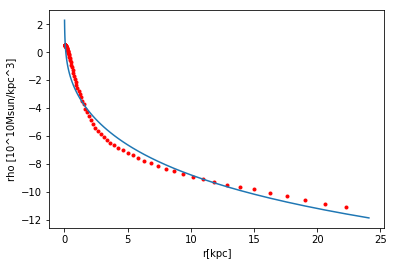

In [14]:
### get everything together somehow 

level = 4
startsnap = 127
endsnap = 128

R0_kpc = 8.
z0_kpc = 0.
r0_kpc = 8.#np.sqrt(R0_kpc**2 + z0_kpc**2)
dr_kpc = 0.5
#j = 0

for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(startsnap,endsnap,1):
        print("snapnr  : {0}".format(snapnr))
        print(datetime.datetime.now().time())
        try:
            s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[1,2,3,4], 
            haloid=0, galradfac=0.1, verbose=False, rotate_disk=False, do_rotation=False, use_principal_axis=False)    
        except KeyError:
            print('\n\n', snapnr, 'not read in.\n\n')
            continue
            
        try: 
            # Clean negative and zero values of gmet to avoid RuntimeErrors
            # later on (e.g. dividing by zero)
            s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
        except:
            continue

            
        disk_ID, spheroid_ID, bulge_ID, halo_ID = decomp(s, r_cutoff_Mpc = 0.05, Gcosmo = 43.0071, plotter = False, disccirc = 0.8)
        
        ## get data from simulations
        i_stars = np.where( (s.halo == 0) & (s.type == 4) )
        i_spheroid = np.isin(s.id[i_stars], spheroid_ID)
        i_disk = np.isin(s.id[i_stars], disk_ID)
        i_dm = np.where( (s.halo == 0) & ((s.type == 1) + (s.type == 2) + (s.type == 3)) )
        
        galrad_kpc = 1000. * s.galrad
        
        # choice of R_kpc_data and z_kpc_data
        (R_kpc, phi, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, i_stars)

        R_kpc_data = R_kpc 
        z_kpc_data = z_kpc
        r_kpc = 1000. * s.r()[i_stars]
        
        
        M_stars_10Msun = s.mass[i_stars]
        M_bulgestars_10Msun = s.mass[i_stars][i_spheroid]
        M_stars_tot_10Msun = np.sum(s.mass[i_stars][i_disk])
        
        
        
        ## fit single parts
        #a_MND_kpc, b_MND_kpc, v_circ_MND = MND(R_kpc_data[i_disk], z_kpc_data[i_disk], M_stars_tot_10Msun, R0_kpc, z0_kpc = 0.)
        a_HB_kpc, v_circ_HB = HB(M_bulgestars_10Msun, r_kpc[i_spheroid], dr_kpc, r0_kpc)
        
        
        #rot curves
        r_kpc           = np.linspace(0, 1000. * s.galrad, 100)
        v_circ_disk     = v_circ_MND_ab(R_kpc=r_kpc, z_kpc=0., a_MND_kpc=a_MND_kpc, b_MND_kpc=b_MND_kpc, M_tot_10Msun=M_stars_tot_10Msun)
        v_circ_spheroid = v_circ_HB_a(r_kpc=r_kpc)#, a_HB_kpc=a_HB_kpc, M_stars_10Msun=M_bulgestars_10Msun)
        v_circ_tot      = v_circ_tot_func(r_kpc=r_kpc)
        v_circ_halo     = v_circ_NFW_func(r_kpc, v_circ_disk, v_circ_spheroid, v_circ_tot)

        # calculate v_circ NFW
        #v_circ_NFW = v_circ_NFW_func(v_circ_MND, v_circ_HB, R0_kpc)
        #print(v_circ_NFW, v_circ_MND, v_circ_HB)
        nn = 35
        R0_ref = r_kpc[nn]
        v0_ref = v_circ_tot[nn]
        n_NFW  = v_circ_halo[nn]** 2      / v_circ_tot[nn] **2
        n_HB   = v_circ_spheroid[nn] ** 2 / v_circ_tot[nn] **2
        n_MND  = v_circ_disk[nn] ** 2     / v_circ_tot[nn] **2
        #print(r_kpc[30], n_NFW + n_HB + n_MND )
        
        part_num = 500
        
        mask, = np.where( (s.halo == 0) & (s.r() < s.galrad) & (s.r() > 0.) & ((s.type == 1) + (s.type == 2) + (s.type == 3) ))


        r_kpc = 1000. * s.r()[mask]
        (R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, mask) 
        pot_kms2 = s.pot[mask]

        # draw random sample out of data
        try:
            rand_samp = np.array(random.sample(list(enumerate(pot_kms2)), part_num))
            rand_ind = rand_samp[:,0].astype(int)
            pot_kms2_data = rand_samp[:, 1]
            r_kpc_data = r_kpc[rand_ind]
            R_kpc_data = R_kpc[rand_ind]
            z_kpc_data = z_kpc[rand_ind]
        except ValueError:        
            pot_kms2_data = pot_kms2
            r_kpc_data = r_kpc
            R_kpc_data = R_kpc
            z_kpc_data = z_kpc
        lower_floor = 1e-3
        bounds = ((lower_floor,500.)) #a_NFWH
        args = (v0_ref, a_MND_kpc, b_MND_kpc, a_HB_kpc, n_MND, n_NFW, R_kpc_data, z_kpc_data, pot_kms2_data, R0_ref)

        
        #fitting:
        res = opt.differential_evolution(
                    rel_pot_error_scipydifferentialevolution,
                    bounds=bounds,
                    args=(R_kpc_data,z_kpc_data,pot_kms2_data, _REFR0_kpc, MND, HB, NFWH),
                    strategy='best1bin',
                    maxiter=1000,tol=0.01,atol=1e-7,
                    disp=False
                    )
        

        a_NFWH_kpc_bestfit = res.x

        print(a_NFWH_kpc_bestfit)


In [117]:
n_NFW = v_circ_halo[30] ** 2 / v_circ_tot[30] **2
n_HB = v_circ_spheroid[30] ** 2 / v_circ_tot[30] **2
n_MND = v_circ_disk[30] ** 2 / v_circ_tot[30] **2
print(r_kpc[30], n_NFW + n_HB + n_MND )

7.2986564853 1.0


In [ ]:

v_circ_NFW = v_circ_NFW_func(v_circ_MND, v_circ_HB, R0_kpc)
print(v_circ_NFW, v_circ_MND, v_circ_HB)
print(np.sqrt(v_circ_NFW**2 + v_circ_HB**2 + v_circ_MND**2))

In [11]:
a_HB_kpc

2.9590661546970285

In [110]:
print(a_MND_kpc, b_MND_kpc, a_HB_kpc
     )

1.3395833448 0.00376836640976 2.26531560773


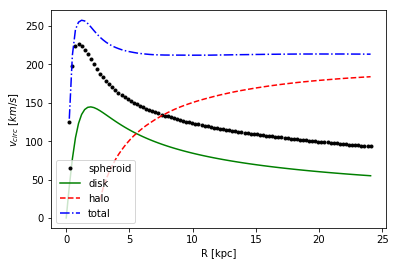

In [116]:
plt.plot(r_kpc, v_circ_spheroid, 'k.', label = 'spheroid')
plt.plot(r_kpc, v_circ_disk, 'g-', label = 'disk')
plt.plot(r_kpc, v_circ_halo, 'r--', label = 'halo')
plt.plot(r_kpc, v_circ_tot, 'b-.', label = 'total')
plt.xlabel('R [kpc]')
plt.ylabel('$v_{circ} \ [km/s]$')
plt.legend()

In [ ]:
level = 4

j = 0
startsnap = 127
endsnap = 128
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(startsnap,endsnap,1):
        #print("level   : {0}".format(level))
        #print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print(datetime.datetime.now().time())
        #print("basedir : {0}".format(basedir))
        #print("halodir : {0}".format(halodir))
        #print("snappath: {0}\n".format(snappath))
        try:
            s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[1,2,3,4], 
            haloid=0, galradfac=0.1, verbose=False, rotate_disk=False, do_rotation=False, use_principal_axis=False) 
        except KeyError:
            print('\n\n', snapnr, 'not read in.\n\n')
            continue

            

In [ ]:
def potential_fit(maxr_Mpc, _REFR0_kpc = 8., mask_num = 2, part_num = 1501, \
                  v0_kms_init = 150., a_MND_kpc_init = 6., b_MND_kpc_init = 1., \
                  a_NFWH_kpc_init = 10., a_HB_kpc_init = 2., n_MND_init = 0.2, n_NFWH_init = 0.6, \
                  fitroutine = 'emcee', nwalkers = 50, nstep = 1000, \
                  comp_mask = None, MND = True, HB = True, NFWH = True, \
                  grav_rad_HB_kpc = 2., \
                  res_arr = [], plot = False, verbose = False):
    
    if comp_mask is None:   
        ### selection masks
        # select ALL particles belonging to the main galaxy within maxr
        if mask_num == 0:
            mask, = np.where( (s.halo == 0) & (s.r() < maxr_Mpc) & (s.r() > 0.) )
            parts_to_fit = 'all'
        # select GAS particles belonging to the main galaxy within maxr
        if mask_num == 1:
            mask, = np.where( (s.halo == 0) & (s.r() < maxr_Mpc) & (s.r() > 0.) & (s.type == 0) )
            parts_to_fit = 'gas'
        # select DM particles belonging to the main galaxy within maxr
        if mask_num == 2:
            mask, = np.where( (s.halo == 0) & (s.r() < maxr_Mpc) & (s.r() > 0.) & ((s.type == 1) + (s.type == 2) + (s.type == 3) ))
            parts_to_fit = 'DM'
        # select STAR particles belonging to the main galaxy within maxr
        if mask_num == 3:
            mask, = np.where( (s.halo == 0) & (s.r() < maxr_Mpc) & (s.r() > 0.) & (s.type == 4) )
            parts_to_fit = 'star'

        if verbose == True:
            print('The potential is fitted to ' + str(part_num) + ' random selected ' + parts_to_fit + ' particles.')

        # select data with mask
        r_kpc = 1000. * s.r()[mask]
        (R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, mask) 
        pot_kms2 = s.pot[mask]

        # draw random sample out of data
        try:
            rand_samp = np.array(random.sample(list(enumerate(pot_kms2)), part_num))
            rand_ind = rand_samp[:,0].astype(int)
            pot_kms2_data = rand_samp[:, 1]
            r_kpc_data = r_kpc[rand_ind]
            R_kpc_data = R_kpc[rand_ind]
            z_kpc_data = z_kpc[rand_ind]
        except ValueError:        
            pot_kms2_data = pot_kms2
            r_kpc_data = r_kpc
            R_kpc_data = R_kpc
            z_kpc_data = z_kpc
            
    else:
        mask = comp_mask
        ## check that the right IDs are selected
        if (MND == 1) * (HB == 1) * (NFWH == 1):
            if np.sum((s.type[mask] == 1) + (s.type[mask] == 2) + (s.type[mask] == 3) + (s.type[mask] == 4)) != np.sum(mask):
                raise ValueError('IDs might be chosen wrong.')
        elif (MND == 1) * (HB == 1) * (NFWH == 0):
            if np.sum(np.where(s.type[mask] != 4)) != 0:
                raise ValueError('IDs might be chosen wrong.')            
        elif (MND == 1) * (HB == 0) * (NFWH == 1):
            if np.sum((s.type[mask] == 1) + (s.type[mask] == 2) + (s.type[mask] == 3) + (s.type[mask] == 4)) != np.sum(mask):
                raise ValueError('IDs might be chosen wrong.')            
        elif (MND == 0) * (HB == 1) * (NFWH == 1):
            if np.sum((s.type[mask] == 1) + (s.type[mask] == 2) + (s.type[mask] == 3) + (s.type[mask] == 4)) != np.sum(mask):
                raise ValueError('IDs might be chosen wrong.')           
        elif (MND == 1) * (HB == 0) * (NFWH == 0):
            if np.sum(np.where(s.type[mask] != 4)) != 0:
                raise ValueError('IDs might be chosen wrong.')
        elif (MND == 0) * (HB == 1) * (NFWH == 0):
            if np.sum(np.where(s.type[mask] != 4)) != 0:
                raise ValueError('IDs might be chosen wrong.')          
        elif (MND == 0) * (HB == 0) * (NFWH == 1):
            if np.sum((s.type[mask] == 1) + (s.type[mask] == 2) + (s.type[mask] == 3)) != np.sum(mask):
                raise ValueError('IDs might be chosen wrong.')
        
        if (MND == 0) * (HB == 1) * (NFWH == 0):
            mask = np.where(((1000. * s.r()[comp_mask]) < grav_rad_HB_kpc))
        
        r_kpc = 1000. * s.r()[mask]
        (R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, mask) 
        pot_kms2 = s.pot[mask] 
        pot_kms2_data = pot_kms2
        r_kpc_data = r_kpc
        R_kpc_data = R_kpc
        z_kpc_data = z_kpc
                    

    if fitroutine == 'emcee': # maybe implement diff ev but not now
        # _____prepare MCMC_____
        ndim, nwalkers, nstep = 7, nwalkers, nstep

        # initial values for fit:
        # init values as input of function
        initial_guess = np.array([v0_kms_init, a_MND_kpc_init, b_MND_kpc_init, a_NFWH_kpc_init, \
                                  a_HB_kpc_init, n_MND_init, n_NFWH_init])
        initial_guess_width = np.fabs(0.2 * initial_guess)
        p0 = np.array([np.random.randn(ndim) * np.array(initial_guess_width) + initial_guess \
                                                      for i in range(nwalkers)])
        # fiitting boundaries:
        boundaries = np.array([[0.,np.inf],[0.,np.inf],[0.,np.inf],[0.,np.inf],[0.,np.inf],[0.,1.],[0.,1.]])
        for pp in range(ndim):
            p0[(p0[:,pp] < boundaries[pp,0]),pp] = initial_guess[pp] + np.random.uniform() * 0.1
            p0[(p0[:,pp] > boundaries[pp,1]),pp] = initial_guess[pp] - np.random.uniform() * 0.1

        # _____run MCMC_____
        sampler = emcee.EnsembleSampler(nwalkers, ndim,
                                       lnprob_MCMC,
                                       args = [R_kpc_data, z_kpc_data, pot_kms2_data, _REFR0_kpc])
        sampler.run_mcmc(p0, nstep)

        # result:
        burnin = int(nwalkers / 2.) # check what this is used for. #1000
        final_samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
        chain_samples = sampler.chain

        median = np.median(final_samples,axis=0)
        std = np.std(final_samples,axis=0)

        v0_kms_bestfit     = median[0]
        a_MND_kpc_bestfit  = median[1]
        b_MND_kpc_bestfit  = median[2]
        a_NFWH_kpc_bestfit = median[3]
        a_HB_kpc_bestfit   = median[4]
        n_MND_bestfit      = median[5]
        n_NFWH_bestfit     = median[6]
        n_HB_bestfit       = 1. - (n_MND_bestfit + n_NFWH_bestfit)

        v0_kms_bestfit_err     = std[0]
        a_MND_kpc_bestfit_err  = std[1]
        b_MND_kpc_bestfit_err  = std[2]
        a_NFWH_kpc_bestfit_err = std[3]
        a_HB_kpc_bestfit_err   = std[4]
        n_MND_bestfit_err      = std[5]
        n_NFWH_bestfit_err     = std[6]
        n_HB_bestfit_err       = (n_MND_bestfit_err + n_NFWH_bestfit_err)

        
        
        # save potential parameters with errors and snapnr:
        pot_bestfit = np.array([v0_kms_bestfit, v0_kms_bestfit_err, a_MND_kpc_bestfit, a_MND_kpc_bestfit_err, \
                            b_MND_kpc_bestfit, b_MND_kpc_bestfit_err, a_NFWH_kpc_bestfit, a_NFWH_kpc_bestfit_err, \
                            a_HB_kpc_bestfit, a_HB_kpc_bestfit_err, n_MND_bestfit, n_MND_bestfit_err, \
                            n_NFWH_bestfit, n_NFWH_bestfit_err, n_HB_bestfit, n_HB_bestfit_err])
        
        res_arr = np.append(res_arr, pot_bestfit)
    
    elif fitroutine == 'diffev':
        lower_floor = 1e-3
        bounds = ((lower_floor,400.), #vcirc
                  (lower_floor,500.), #a_MND
                  (lower_floor,100.), #b_MND
                  (lower_floor,500.), #a_NFWH
                  (lower_floor,500.), #a_HB
                  (0., 1.), #n_MND
                  (0., 1.)) #n_NFWH

        #fitting:
        res = opt.differential_evolution(
                    rel_pot_error_scipydifferentialevolution,
                    bounds=bounds,
                    args=(R_kpc_data,z_kpc_data,pot_kms2_data, _REFR0_kpc, MND, HB, NFWH),
                    strategy='best1bin',
                    maxiter=1000,tol=0.01,atol=1e-7,
                    disp=False
                    )
        
        v0_kms_bestfit     = res.x[0]
        a_MND_kpc_bestfit  = res.x[1]
        b_MND_kpc_bestfit  = res.x[2]
        a_NFWH_kpc_bestfit = res.x[3]
        a_HB_kpc_bestfit   = res.x[4]
        n_MND_bestfit      = res.x[5]
        n_NFWH_bestfit     = res.x[6]
        n_HB_bestfit       = 1. - (n_MND_bestfit + n_NFWH_bestfit)


        pot_bestfit = np.array([v0_kms_bestfit, a_MND_kpc_bestfit, b_MND_kpc_bestfit, a_NFWH_kpc_bestfit, \
                            a_HB_kpc_bestfit, n_MND_bestfit, n_NFWH_bestfit, n_HB_bestfit])
        res_arr = np.append(res_arr, pot_bestfit)

   
    
    # generate potential measurements:
    if plot == True:
        pot_galpy_bestfit = setup_galpy_potential(a_MND_kpc_bestfit,b_MND_kpc_bestfit,
                                               a_NFWH_kpc_bestfit,a_HB_kpc_bestfit,
                                               n_MND_bestfit,n_NFWH_bestfit,n_HB_bestfit, _REFR0_kpc)
        pot_kms2_bestfit = evaluatePotentials(pot_galpy_bestfit,
                                           R_kpc_data/_REFR0_kpc,
                                           z_kpc_data/_REFR0_kpc) * (v0_kms_bestfit)**2
                               
        plotDensities(pot_galpy_bestfit,rmin=0.1,zmax=0.25,zmin=-0.25,nrs=101,nzs=101)
        plt.show()
                               
                               
    if fitroutine == 'emcee':
        sampler.reset()

                               
    return res_arr

In [ ]:
fitroutine = 'diffev' #emcee
dopotfit = False
if dopotfit == True:
#### path = /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/*
    level = 4

    j = 0
    startsnap = 60
    endsnap = 128
    for halo_number in [24]:  # range(1, 31):
        halodir = basedir+"halo_{0}/".format(halo_number)
        snappath = halodir+"output/"
        for snapnr in range(startsnap,endsnap,1):
            #print("level   : {0}".format(level))
            #print("halo    : {0}".format(halo_number))
            print("snapnr  : {0}".format(snapnr))
            print(datetime.datetime.now().time())
            #print("basedir : {0}".format(basedir))
            #print("halodir : {0}".format(halodir))
            #print("snappath: {0}\n".format(snappath))
            try:
                s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[1,2,3], 
                haloid=0, galradfac=0.1, verbose=False, rotate_disk=False, do_rotation=False, use_principal_axis=False) 
            except KeyError:
                print('\n\n', snapnr, 'not read in.\n\n')
                continue

            if fitroutine == 'emcee':
                file = filedir + 'potential_params_emcee_10000_with_initeqbestfit.txt'
                savefile = filedir + 'potential_params_emcee_10000_with_initeqbestfit_safetyfile.txt'
                firstline = "#snapnr\tv0_kms_bestfit\tv0_kms_bestfit_err\ta_MND_kpc_bestfit\ta_MND_kpc_bestfit_err\tb_MND_kpc_bestfit\tb_MND_kpc_bestfit_err\ta_NFWH_kpc_bestfit\ta_NFWH_kpc_bestfit_err\ta_HB_kpc_bestfit\ta_HB_kpc_bestfit_err\tn_MND_bestfit\tn_MND_bestfit_err\tn_NFWH_bestfit\tn_NFWH_bestfit_err\tn_HB_bestfit\tn_HB_bestfit_err\n"
                if j == 0:
                    res_arr = potential_fit(maxr_Mpc = 2. * s.galrad, part_num = 175000, nstep = 2000)
                    res_arr = np.insert(res_arr, 0, snapnr)
                    j +=1
                    v0_kms_bestfit      = res_arr[int(17 * (snapnr - startsnap )) + 1]
                    a_MND_kpc_bestfit   = res_arr[int(17 * (snapnr - startsnap )) + 3]
                    b_MND_kpc_bestfit   = res_arr[int(17 * (snapnr - startsnap )) + 5]
                    a_NFWH_kpc_bestfit  = res_arr[int(17 * (snapnr - startsnap )) + 7]
                    a_HB_kpc_bestfit    = res_arr[int(17 * (snapnr - startsnap )) + 9]
                    n_MND_bestfit       = res_arr[int(17 * (snapnr - startsnap )) + 11]
                    n_NFWH_bestfit      = res_arr[int(17 * (snapnr - startsnap )) + 13]
                    n_HB_bestfit        = res_arr[int(17 * (snapnr - startsnap )) + 15]


                else:
                    res_arr = potential_fit(maxr_Mpc = 2. * s.galrad, part_num = 175000, nstep = 2000, res_arr=res_arr, \
                                            v0_kms_init = v0_kms_bestfit, a_MND_kpc_init = a_MND_kpc_bestfit, \
                                            b_MND_kpc_init = b_MND_kpc_bestfit, a_NFWH_kpc_init = a_NFWH_kpc_bestfit, \
                                            a_HB_kpc_init = a_HB_kpc_bestfit, n_MND_init = n_MND_bestfit, \
                                            n_NFWH_init = n_NFWH_bestfit)
                    res_arr = np.insert(res_arr, 17 * (snapnr - startsnap ), snapnr)

                    v0_kms_bestfit      = res_arr[int(17 * (snapnr - startsnap )) + 1]
                    a_MND_kpc_bestfit   = res_arr[int(17 * (snapnr - startsnap )) + 3]
                    b_MND_kpc_bestfit   = res_arr[int(17 * (snapnr - startsnap )) + 5]
                    a_NFWH_kpc_bestfit  = res_arr[int(17 * (snapnr - startsnap )) + 7]
                    a_HB_kpc_bestfit    = res_arr[int(17 * (snapnr - startsnap )) + 9]
                    n_MND_bestfit       = res_arr[int(17 * (snapnr - startsnap )) + 11]
                    n_NFWH_bestfit      = res_arr[int(17 * (snapnr - startsnap )) + 13]
                    n_HB_bestfit        = res_arr[int(17 * (snapnr - startsnap )) + 15]

                #print(res_arr)

                if (snapnr % 10) ==0:
                    f = open(file, 'w') # existing file will be overwritten
                    f.write(firstline)
                    f.close()
                    f = open(file,'ab') # open file in append and binary mode to make savetxt work and append
                    np.savetxt(f,res_arr)
                    f.close()
                    
            elif fitroutine == 'diffev':
                file = filedir + 'potential_params_diffev.txt'
                savefile = filedir + 'potential_params_diffev_safetyfile.txt'
                firstline = "#snapnr\tv0_kms_bestfit\ta_MND_kpc_bestfit\tb_MND_kpc_bestfit\ta_NFWH_kpc_bestfit\ta_HB_kpc_bestfit\tn_MND_bestfit\tn_NFWH_bestfit\tn_HB_bestfit\n"
                if j == 0:
                    res_arr = potential_fit(maxr_Mpc = 2. * s.galrad, fitroutine = 'diffev')
                    res_arr = np.insert(res_arr, 0, snapnr)
                    j +=1
                    '''
                    v0_kms_bestfit      = res_arr[int(9 * (snapnr - startsnap )) + 1]
                    a_MND_kpc_bestfit   = res_arr[int(9 * (snapnr - startsnap )) + 2]
                    b_MND_kpc_bestfit   = res_arr[int(9 * (snapnr - startsnap )) + 3]
                    a_NFWH_kpc_bestfit  = res_arr[int(9 * (snapnr - startsnap )) + 4]
                    a_HB_kpc_bestfit    = res_arr[int(9 * (snapnr - startsnap )) + 5]
                    n_MND_bestfit       = res_arr[int(9 * (snapnr - startsnap )) + 6]
                    n_NFWH_bestfit      = res_arr[int(9 * (snapnr - startsnap )) + 7]
                    n_HB_bestfit        = res_arr[int(9 * (snapnr - startsnap )) + 8]
                    '''
                    res_len = len(res_arr)

                else:
                    res_arr = potential_fit(maxr_Mpc = 2. * s.galrad, res_arr=res_arr, fitroutine = 'diffev')
                    res_arr = np.insert(res_arr, res_len * (snapnr - startsnap ), snapnr)

                    '''
                    v0_kms_bestfit      = res_arr[int(9 * (snapnr - startsnap )) + 1]
                    a_MND_kpc_bestfit   = res_arr[int(9 * (snapnr - startsnap )) + 2]
                    b_MND_kpc_bestfit   = res_arr[int(9 * (snapnr - startsnap )) + 3]
                    a_NFWH_kpc_bestfit  = res_arr[int(9 * (snapnr - startsnap )) + 4]
                    a_HB_kpc_bestfit    = res_arr[int(9 * (snapnr - startsnap )) + 5]
                    n_MND_bestfit       = res_arr[int(9 * (snapnr - startsnap )) + 6]
                    n_NFWH_bestfit      = res_arr[int(9 * (snapnr - startsnap )) + 7]
                    n_HB_bestfit        = res_arr[int(9 * (snapnr - startsnap )) + 8]
                    '''
                #print(res_arr)

                if (snapnr % 10) ==0:
                    f = open(file, 'w') # existing file will be overwritten
                    f.write(firstline)
                    f.close()
                    f = open(file,'ab') # open file in append and binary mode to make savetxt work and append
                    np.savetxt(f,res_arr)
                    f.close()
    if fitroutine == 'emcee':     
        res_arr = res_arr.reshape(endsnap-startsnap,17) # instead of 4 number of simulations fitted
    elif fitroutine == 'diffev':
        res_arr = res_arr.reshape(endsnap-startsnap,9)
            

    np.savetxt(savefile, res_arr)

    f = open(file, 'w') # existing file will be overwritten
    f.write(firstline)
    f.close()
    f = open(file,'ab') # open file in append and binary mode to make savetxt work and append
    np.savetxt(f,res_arr)
    f.close()


In [ ]:
### fit disk stars to MND pot, and bulge stars the HB pot; keep'em fixed ###
### save their params for every snapshot since 60 or 70 ###
### then have varying potential for halo (DM particles) ###
level = 4

fitroutine = 'diffev'

jdisk  = 0
jbulge = 0
jhalo  = 0

startsnap = 60
endsnap = 128
for halo_number in [24]:  # range(1, 31):
    halodir = basedir + "halo_{0}/".format(halo_number)
    snappath = halodir + "output/"
    
    for snapnr in range(startsnap, endsnap, 1):
        print("snapnr  : {0}".format(snapnr))
        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[4], 
            haloid=0, galradfac=0.1, verbose=True) 

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
    
        print('start decomposition')
        disk_ID, spheroid_ID, bulge_ID, halo_ID = decomp(s, r_cutoff_Mpc = s.galrad)
        
        idisk = np.isin(s.id, disk_ID)
        ibulge = np.isin(s.id, bulge_ID)
        ispheroid = np.isin(s.id, spheroid_ID)
        ihalo = np.isin(s.id, halo_ID)        
        ihalo = np.where((s.type == 1) + (s.type == 2) + (s.type == 3))
        ## fit disk
        '''
        print('start disk fit')
        if fitroutine == 'diffev':
            file_disk = filedir + 'potential_params_MND_diffev.txt'
            savefile_disk = filedir + 'potential_params_MND_diffev_safetyfile.txt'
            firstline_disk = "#snapnr\tv0_kms_bestfit\ta_MND_kpc_bestfit\tb_MND_kpc_bestfit\ta_NFWH_kpc_bestfit\ta_HB_kpc_bestfit\tn_MND_bestfit\tn_NFWH_bestfit\tn_HB_bestfit\n"
            if jdisk == 0:
                res_arr_disk = potential_fit(maxr_Mpc = 2. * s.galrad, comp_mask = idisk, MND = True, HB = False, NFWH = False, fitroutine = 'diffev')
                res_arr_disk = np.insert(res_arr_disk, 0, snapnr)
                jdisk +=1
                res_len_disk = len(res_arr_disk)
            else:
                res_arr_disk = potential_fit(maxr_Mpc = 2. * s.galrad, comp_mask = idisk, MND = True, HB = False, NFWH = False, res_arr=res_arr_disk, fitroutine = 'diffev', plot= True)
                res_arr_disk = np.insert(res_arr_disk, res_len_disk * (snapnr - startsnap ), snapnr)
        '''
        
        
        ## fit bulge 
        print('start bulge fit')
        # according to B&T 2008 p71 the gravitational radius of the Hernquist profile = 6a; 
        # a is one fitting component
        # take i_spheroid for first fit, for 2nd and further fit tries set as radius for stars to be fitted 6 * a_HB of the prior fit        
        if fitroutine == 'diffev':
            file_bulge = filedir + 'potential_params_HB_diffev_rg6a.txt'
            savefile_bulge = filedir + 'potential_params_HB_diffev_safetyfile_rg6a.txt'
            firstline_bulge = "#snapnr\tv0_kms_bestfit\ta_MND_kpc_bestfit\tb_MND_kpc_bestfit\ta_NFWH_kpc_bestfit\ta_HB_kpc_bestfit\tn_MND_bestfit\tn_NFWH_bestfit\tn_HB_bestfit\n"
            if jbulge == 0:
                res_arr_bulge = potential_fit(maxr_Mpc = s.galrad, comp_mask = ispheroid, MND = False, HB = True, NFWH = False, grav_rad_HB_kpc = s.galrad, fitroutine = 'diffev')
                res_arr_bulge = np.insert(res_arr_bulge, 0, snapnr)
                jbulge +=1
                res_len_bulge = len(res_arr_bulge)
                a_HB_kpc_bestfit = res_arr_bulge[int(res_len_bulge * (snapnr - startsnap )) + 5]
            else:
                res_arr_bulge = potential_fit(maxr_Mpc = s.galrad, comp_mask = ispheroid, MND = False, HB = True, NFWH = False, grav_rad_HB_kpc = 6. * a_HB_kpc_bestfit, res_arr=res_arr_bulge, fitroutine = 'diffev', plot = True)
                res_arr_bulge = np.insert(res_arr_bulge, res_len_bulge * (snapnr - startsnap ), snapnr)
                a_HB_kpc_bestfit = res_arr_bulge[int(res_len_bulge * (snapnr - startsnap )) + 5]

        
        
        
        ## fit halo (variable)
print('save everything')        
if fitroutine == 'diffev':
    '''
    res_arr_disk = res_arr_disk.reshape(endsnap-startsnap,res_len_disk)
    np.savetxt(savefile_disk, res_arr_disk)

    f = open(file_disk, 'w') # existing file will be overwritten
    f.write(firstline_disk)
    f.close()
    f = open(file_disk,'ab') # open file in append and binary mode to make savetxt work and append
    np.savetxt(f,res_arr_disk)
    f.close()
    '''
    
    res_arr_bulge = res_arr_bulge.reshape(endsnap-startsnap,res_len_bulge)
    np.savetxt(savefile_bulge, res_arr_bulge)

    f = open(file_bulge, 'w') # existing file will be overwritten
    f.write(firstline_bulge)
    f.close()
    f = open(file_bulge,'ab') # open file in append and binary mode to make savetxt work and append
    np.savetxt(f,res_arr_bulge)
    f.close()

In [ ]:
diskfile = filedir + 'potential_params_MND_diffev.txt'
bulgefile = filedir + 'potential_params_HB_diffev.txt'
bulgefile6a = filedir + 'potential_params_HB_diffev_rg6a.txt'
v0_kms_disk, a_MND_kpc, b_MND_kpc = np.loadtxt(diskfile, usecols = (1,2,3), unpack=True)
v0_kms_bulge, a_HB_kpc = np.loadtxt(bulgefile, usecols=(1,5), unpack=True)
v0_kms_bulge6a, a_HB_kpc6a = np.loadtxt(bulgefile6a, usecols=(1,5), unpack=True)


snapnr = np.arange(60,128,1)



labelsdisk = ["v0_kms","a_MND_kpc","b_MND_kpc"]
labelsbulge = ["v0_kms", "a_HB_kpc"]

paramsdisk = np.vstack([v0_kms_disk, a_MND_kpc, b_MND_kpc])
paramsbulge = np.vstack([v0_kms_bulge, a_HB_kpc])
paramsbulge6a = np.vstack([v0_kms_bulge6a, a_HB_kpc6a])

ndim = 3
f, axes = plt.subplots(ndim, 1, figsize=(12,6))
for ii in range(ndim):
    axes[ii].set_xlim(59,131)
    axes[ii].set_ylabel(labelsdisk[ii])
    if ii == (ndim - 1):
        axes[ii].set_xlabel('Snapshot number')
    #axes[ii,1].set_ylabel(labels[ii])
    axes[ii].plot(snapnr, paramsdisk[ii], 'k.')    
    #axes[ii,1].set_yscale('log', nonposy="clip")
    #zz = np.polyfit(snapnr[4:], params[ii][4:], jj, w = (1./params_err[ii][4:]), full = True)
    #p = np.poly1d(zz[0])
    #xp = np.linspace(np.min(snapnr[4:]), np.max(snapnr[4:]), int (np.max(snapnr[4:]) - np.min(snapnr[4:])))
    #axes[ii].plot(xp, p(xp), 'g-', label = str(jj ) + ' polynoms')
    #axes[ii].legend()
    #fitted_params.append(p(xp))
f.tight_layout()

#fitted_params = np.array(fitted_params)
#keep normalization of n_vals"
#normfac = (fitted_params[5] + fitted_params[6] + fitted_params[7])
#fitted_params[5] = fitted_params[5] / normfac
#fitted_params[6] = fitted_params[6] / normfac
#fitted_params[7] = fitted_params[7] / normfac

ndim = 4
f, axes = plt.subplots(ndim, 1, figsize=(12,6))
for ii in range(ndim):
    
    if ii == (ndim - 1):
        axes[ii].set_xlim(59,131)
        axes[ii].set_ylabel(labelsbulge[ii-2])
        axes[ii].set_xlabel('Snapshot number')
        axes[ii].plot(snapnr[14:], paramsbulge[ii-2][14:], 'r.', label = 'grav radius = a_HB') 
        axes[ii].plot(snapnr[14:], paramsbulge6a[ii-2][14:], 'g.', label = 'grav radius = 6 * a_HB' )
    elif ii == (ndim - 2):
        axes[ii].set_xlim(59,131)
        axes[ii].set_ylabel(labelsbulge[ii-1])
        axes[ii].set_xlabel('Snapshot number')
        axes[ii].plot(snapnr[2:], paramsbulge[ii-1][2:], 'r.', label = 'grav radius = a_HB') 
        axes[ii].plot(snapnr[2:], paramsbulge6a[ii-1][2:], 'g.', label = 'grav radius = 6 * a_HB' )
    #axes[ii,1].set_ylabel(labels[ii])
    else:
        axes[ii].set_ylabel(labelsbulge[ii])
        axes[ii].set_xlim(59,131)
        axes[ii].plot(snapnr, paramsbulge[ii], 'r.', label = 'grav radius = a_HB') 
        axes[ii].plot(snapnr, paramsbulge6a[ii], 'g.', label = 'grav radius = 6 * a_HB' ) 
    
    #axes[ii,1].set_yscale('log', nonposy="clip")
    #zz = np.polyfit(snapnr[4:], params[ii][4:], jj, w = (1./params_err[ii][4:]), full = True)
    #p = np.poly1d(zz[0])
    #xp = np.linspace(np.min(snapnr[4:]), np.max(snapnr[4:]), int (np.max(snapnr[4:]) - np.min(snapnr[4:])))
    #axes[ii].plot(xp, p(xp), 'g-', label = str(jj ) + ' polynoms')
    axes[ii].legend()
    #fitted_params.append(p(xp))
f.tight_layout()

#fitted_params.reshape(int(len(fitted_params)/7),7)
    #display(f)
#f.savefig(plotdir + 'parameter_evolution_lin_'+ str(jj)+'polynomsfit.png', dpi = 300, bbox_inches = 'tight', format = 'png')

In [ ]:
for i in range(len(snapnr)):
    diskpot = MiyamotoNagaiPotential(a_MND_kpc[i], b_MND_kpc[i], normalize = 0.5)
    bulgepot = HernquistPotential(a_HB_kpc[i], normalize = 0.5)
    pot = [diskpot, bulgepot]
    plotDensities(pot,rmin=0.1,zmax=0.25,zmin=-0.25,nrs=101,nzs=101, log = True )
    plt.text(1.2, 0.2, 'Snap ' + str(i+60), color = 'red')#, horizontalalignment='center',verticalalignment='center')#, transform=ax.transAxes)
    plt.show()


In [ ]:
np.sum(s.mass[ibulge])

In [ ]:
np.sum(s.mass[idisk])